<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D4_DynamicNetworks/W2D4_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Wilson-Cowan Model
**Week 2, Day 4: Dynamic Networks**

**By Neuromatch Academy**

__Content creators:__ Qinglong Gu, Songtin Li, Arvind Kumar, John Murray, Julijana Gjorgjieva 

__Content reviewers:__ Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Spiros Chavlis, Michael Waskom, Siddharth Suresh

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 1 hour, 35 minutes*

In the previous tutorial, you became familiar with a neuronal network consisting of only an excitatory population. Here, we extend the approach we used to include both excitatory and inhibitory neuronal populations in our network. A simple, yet powerful model to study the dynamics of two interacting populations of excitatory and inhibitory neurons, is the so-called **Wilson-Cowan** rate model, which will be the subject of this tutorial.

The objectives of this tutorial are to:

- Write the **Wilson-Cowan** equations for the firing rate dynamics of a 2D system composed of an excitatory (E) and an inhibitory (I) population of neurons
- Simulate the dynamics of the system, i.e., Wilson-Cowan model.
- Plot the frequency-current (F-I) curves for both populations (i.e., E and I).
- Visualize and inspect the behavior of the system using **phase plane analysis**, **vector fields**, and **nullclines**.

Bonus steps:

- Find and plot the **fixed points** of the Wilson-Cowan model.
- Investigate the stability of the Wilson-Cowan model by linearizing its dynamics and examining the **Jacobian matrix**.
- Learn how the Wilson-Cowan model can reach an oscillatory state.

Bonus steps (applications):
- Visualize the behavior of an Inhibition-stabilized network.
- Simulate working memory using the Wilson-Cowan model.

\\
Reference paper:

_[Wilson H and Cowan J (1972) Excitatory and inhibitory interactions in localized populations of model neurons. Biophysical Journal 12](https://doi.org/10.1016/S0006-3495(72)86068-5)_

In [ ]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/nvuty/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt       # root-finding algorithm

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Plotting Functions



def plot_FI_inverse(x, a, theta):
  f, ax = plt.subplots()
  ax.plot(x, F_inv(x, a=a, theta=theta))
  ax.set(xlabel="$x$", ylabel="$F^{-1}(x)$")


def plot_FI_EI(x, FI_exc, FI_inh):
  plt.figure()
  plt.plot(x, FI_exc, 'b', label='E population')
  plt.plot(x, FI_inh, 'r', label='I population')
  plt.legend(loc='lower right')
  plt.xlabel('x (a.u.)')
  plt.ylabel('F(x)')
  plt.show()


def my_test_plot(t, rE1, rI1, rE2, rI2):

  plt.figure()
  ax1 = plt.subplot(211)
  ax1.plot(pars['range_t'], rE1, 'b', label='E population')
  ax1.plot(pars['range_t'], rI1, 'r', label='I population')
  ax1.set_ylabel('Activity')
  ax1.legend(loc='best')

  ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
  ax2.plot(pars['range_t'], rE2, 'b', label='E population')
  ax2.plot(pars['range_t'], rI2, 'r', label='I population')
  ax2.set_xlabel('t (ms)')
  ax2.set_ylabel('Activity')
  ax2.legend(loc='best')

  plt.tight_layout()
  plt.show()


def plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI):

  plt.figure()
  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')
  plt.show()


def my_plot_nullcline(pars):
  Exc_null_rE = np.linspace(-0.01, 0.96, 100)
  Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
  Inh_null_rI = np.linspace(-.01, 0.8, 100)
  Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

  plt.plot(Exc_null_rE, Exc_null_rI, 'b', label='E nullcline')
  plt.plot(Inh_null_rE, Inh_null_rI, 'r', label='I nullcline')
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')
  plt.legend(loc='best')


def my_plot_vector(pars, my_n_skip=2, myscale=5):
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)

  n_skip = my_n_skip

  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=myscale, facecolor='c')

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars = pars.copy()
  pars['rE_init'], pars['rI_init'] = x_init[0], x_init[1]
  rE_tj, rI_tj = simulate_wc(**pars)

  plt.plot(rE_tj, rI_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)
  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Solve for I along the E_grid from dE/dt = 0.

  Expects:
  pars    : Parameter dictionary
  dx      : increment of initial values
  n       : n*n trjectories
  mylabel : label for legend

  Returns:
    figure of trajectory
  """
  pars = pars.copy()
  for ie in range(n):
    for ii in range(n):
      pars['rE_init'], pars['rI_init'] = dx * ie, dx * ii
      rE_tj, rI_tj = simulate_wc(**pars)
      if (ie == n-1) & (ii == n-1):
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8, label=mylabel)
      else:
          plt.plot(rE_tj, rI_tj, 'gray', alpha=0.8)

  plt.xlabel(r'$r_E$')
  plt.ylabel(r'$r_I$')


def plot_complete_analysis(pars):
  plt.figure(figsize=(7.7, 6.))

  # plot example trajectories
  my_plot_trajectories(pars, 0.2, 6,
                       'Sample trajectories \nfor different init. conditions')
  my_plot_trajectory(pars, 'orange', [0.6, 0.8],
                     'Sample trajectory for \nlow activity')
  my_plot_trajectory(pars, 'm', [0.6, 0.6],
                     'Sample trajectory for \nhigh activity')

  # plot nullclines
  my_plot_nullcline(pars)

  # plot vector field
  EI_grid = np.linspace(0., 1., 20)
  rE, rI = np.meshgrid(EI_grid, EI_grid)
  drEdt, drIdt = EIderivs(rE, rI, **pars)
  n_skip = 2
  plt.quiver(rE[::n_skip, ::n_skip], rI[::n_skip, ::n_skip],
             drEdt[::n_skip, ::n_skip], drIdt[::n_skip, ::n_skip],
             angles='xy', scale_units='xy', scale=5., facecolor='c')

  plt.legend(loc=[1.02, 0.57], handlelength=1)
  plt.show()


def plot_fp(x_fp, position=(0.02, 0.1), rotation=0):
  plt.plot(x_fp[0], x_fp[1], 'ko', ms=8)
  plt.text(x_fp[0] + position[0], x_fp[1] + position[1],
           f'Fixed Point1=\n({x_fp[0]:.3f}, {x_fp[1]:.3f})',
           horizontalalignment='center', verticalalignment='bottom',
           rotation=rotation)

In [4]:
# @title Helper Functions

def default_pars(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau_E'] = 1.     # Timescale of the E population [ms]
  pars['a_E'] = 1.2      # Gain of the E population
  pars['theta_E'] = 2.8  # Threshold of the E population

  # Inhibitory parameters
  pars['tau_I'] = 2.0    # Timescale of the I population [ms]
  pars['a_I'] = 1.0      # Gain of the I population
  pars['theta_I'] = 4.0  # Threshold of the I population

  # Connection strength
  pars['wEE'] = 9.   # E to E
  pars['wEI'] = 4.   # I to E
  pars['wIE'] = 13.  # E to I
  pars['wII'] = 11.  # I to I

  # External input
  pars['I_ext_E'] = 0.
  pars['I_ext_I'] = 0.

  # simulation parameters
  pars['T'] = 50.        # Total duration of simulation [ms]
  pars['dt'] = .1        # Simulation time step [ms]
  pars['rE_init'] = 0.2  # Initial value of E
  pars['rI_init'] = 0.2  # Initial value of I

  # External parameters if any
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f


def dF(x, a, theta):
  """
  Derivative of the population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    dFdx  :  Derivative of the population activation function.
  """

  dFdx = a * np.exp(-a * (x - theta)) * (1 + np.exp(-a * (x - theta)))**-2

  return dFdx

The helper functions included:

- Parameter dictionary: `default_pars(**kwargs)`. You can use:
  - `pars = default_pars()` to get all the parameters, and then you can execute `print(pars)` to check these parameters. 
  - `pars = default_pars(T=T_sim, dt=time_step)` to set a different simulation time and time step
  - After `pars = default_pars()`, use `par['New_para'] = value` to add a new parameter with its value
  - Pass to functions that accept individual parameters with `func(**pars)`
- F-I curve: `F(x, a, theta)`
- Derivative of the F-I curve: `dF(x, a, theta)`

---
# Section 1: Wilson-Cowan model of excitatory and inhibitory populations


In [5]:
# @title Video 1: Phase analysis of the Wilson-Cowan E-I model
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1CD4y1m7dK", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="GCpQmh45crM", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

This video explains how to model a network with interacting populations of excitatory and inhibitory neurons (the Wilson-Cowan model). It shows how to solve the network activity vs. time and introduces the phase plane in two dimensions.

## Section 1.1: Mathematical description of the WC model

*Estimated timing to here from start of tutorial: 12 min*

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

Many of the rich dynamics recorded in the brain are generated by the interaction of excitatory and inhibitory subtype neurons. Here, similar to what we did in the previous tutorial, we will model two coupled populations of E and I neurons (**Wilson-Cowan** model). We can write two coupled differential equations, each representing the dynamics of the excitatory or inhibitory population:

\begin{align}
\tau_E \frac{dr_E}{dt} &= -r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E)\\
\tau_I \frac{dr_I}{dt} &= -r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I)    \qquad (1)
\end{align}

$r_E(t)$ represents the average activation (or firing rate) of the excitatory population at time $t$, and $r_I(t)$ the activation (or firing rate) of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of the dynamics of each population. Connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). The terms $w_{EI}$ and $w_{IE}$ represent connections from inhibitory to excitatory population and vice versa, respectively. The transfer functions (or F-I curves) $F_E(x;a_E,\theta_E)$ and $F_I(x;a_I,\theta_I)$ can be different for the excitatory and the inhibitory populations.


### Coding Exercise 1.1: Plot out the F-I curves for the E and I populations 

Let's first plot out the F-I curves for the E and I populations using the helper function `F` with default parameter values.

In [6]:
help(F)

Help on function F in module __main__:

F(x, a, theta)
    Population activation function, F-I curve
    
    Args:
      x     : the population input
      a     : the gain of the function
      theta : the threshold of the function
    
    Returns:
      f     : the population activation response f(x) for input x



1.2 2.8
1.0 4.0


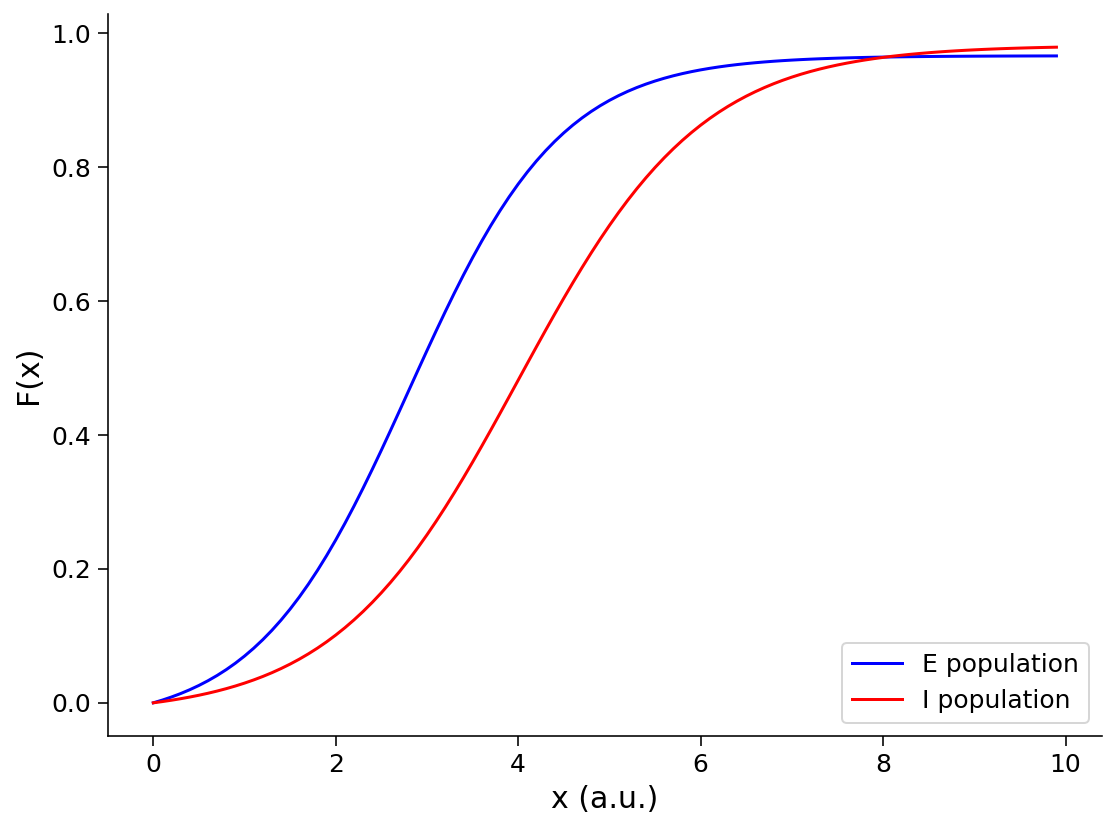

In [8]:
pars = default_pars()
x = np.arange(0, 10, .1)

print(pars['a_E'], pars['theta_E'])
print(pars['a_I'], pars['theta_I'])

###################################################################
# TODO for students: compute and plot the F-I curve here          #
# Note: aE, thetaE, aI and theta_I are in the dictionray 'pars'   #
#raise NotImplementedError('student exercise: compute F-I curves of excitatory and inhibitory populations')
###################################################################

# Compute the F-I curve of the excitatory population
FI_exc = F(x, a=pars['a_E'], theta=pars['theta_E'])

# Compute the F-I curve of the inhibitory population
FI_inh = F(x, a=pars['a_I'], theta=pars['theta_I'])

# Visualize
plot_FI_EI(x, FI_exc, FI_inh)

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


1.2 2.8
1.0 4.0


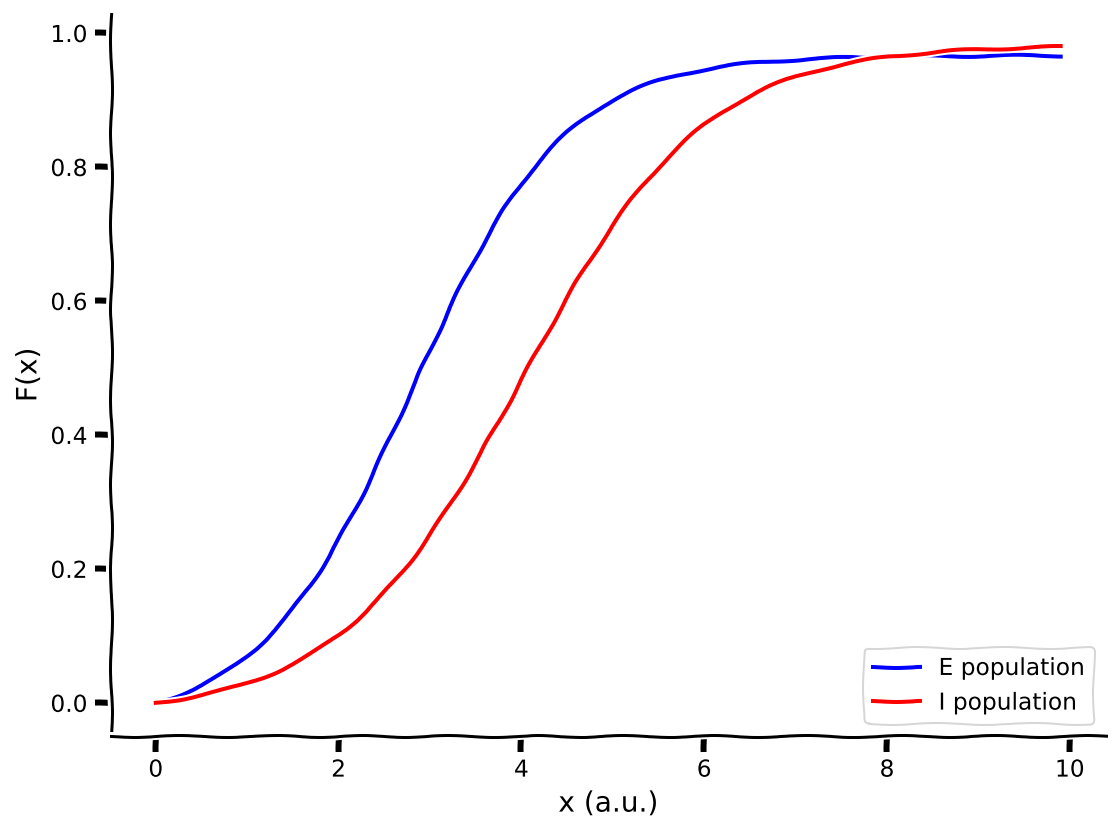

In [9]:
# to_remove solution
pars = default_pars()
x = np.arange(0, 10, .1)

print(pars['a_E'], pars['theta_E'])
print(pars['a_I'], pars['theta_I'])

# Compute the F-I curve of the excitatory population
FI_exc = F(x, pars['a_E'], pars['theta_E'])

# Compute the F-I curve of the inhibitory population
FI_inh = F(x, pars['a_I'], pars['theta_I'])

# Visualize
with plt.xkcd():
  plot_FI_EI(x, FI_exc, FI_inh)

## Section 1.2: Simulation scheme for the Wilson-Cowan model

*Estimated timing to here from start of tutorial: 20 min*

Once again, we can integrate our equations numerically. Using the Euler method, the dynamics of E and I populations can be simulated on a time-grid of stepsize $\Delta t$. The updates for the activity of the excitatory and the inhibitory populations can be written as:

\begin{align}
r_E[k+1] &= r_E[k] + \Delta r_E[k]\\
r_I[k+1] &= r_I[k] + \Delta r_I[k] 
\end{align}

with the increments

\begin{align}
\Delta r_E[k] &= \frac{\Delta t}{\tau_E}[-r_E[k] + F_E(w_{EE}r_E[k] -w_{EI}r_I[k] + I^{\text{ext}}_E[k];a_E,\theta_E)]\\
\Delta r_I[k] &= \frac{\Delta t}{\tau_I}[-r_I[k] + F_I(w_{IE}r_E[k] -w_{II}r_I[k] + I^{\text{ext}}_I[k];a_I,\theta_I)] 
\end{align}

### Coding Exercise 1.2: Numerically integrate the Wilson-Cowan equations

We will implemenent this numerical simulation of our equations and visualize two simulations with similar initial points.

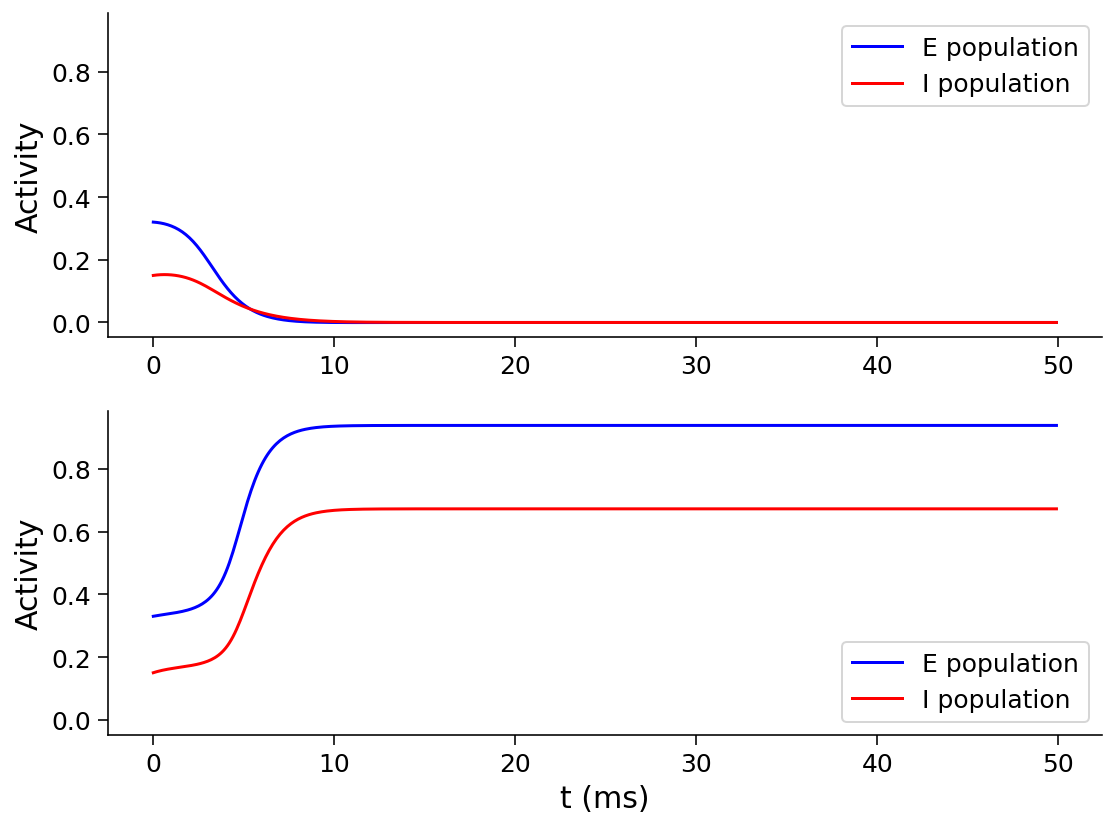

In [13]:
def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    ########################################################################
    # TODO for students: compute drE and drI and remove the error
    #raise NotImplementedError("Student exercise: compute the change in E/I")
    ########################################################################

    # Calculate the derivative of the E population
    drE = ( dt / tau_E ) * ( - rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k], a_E, theta_E) )

    # Calculate the derivative of the I population
    drI = ( dt / tau_I ) * ( - rI[k] + F(- wII * rI[k] + wIE * rE[k] + I_ext_I[k], a_I, theta_I) )

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI


pars = default_pars()

# Simulate first trajectory
rE1, rI1 = simulate_wc(**default_pars(rE_init=.32, rI_init=.15))

# Simulate second trajectory
rE2, rI2 = simulate_wc(**default_pars(rE_init=.33, rI_init=.15))

# Visualize
my_test_plot(pars['range_t'], rE1, rI1, rE2, rI2)

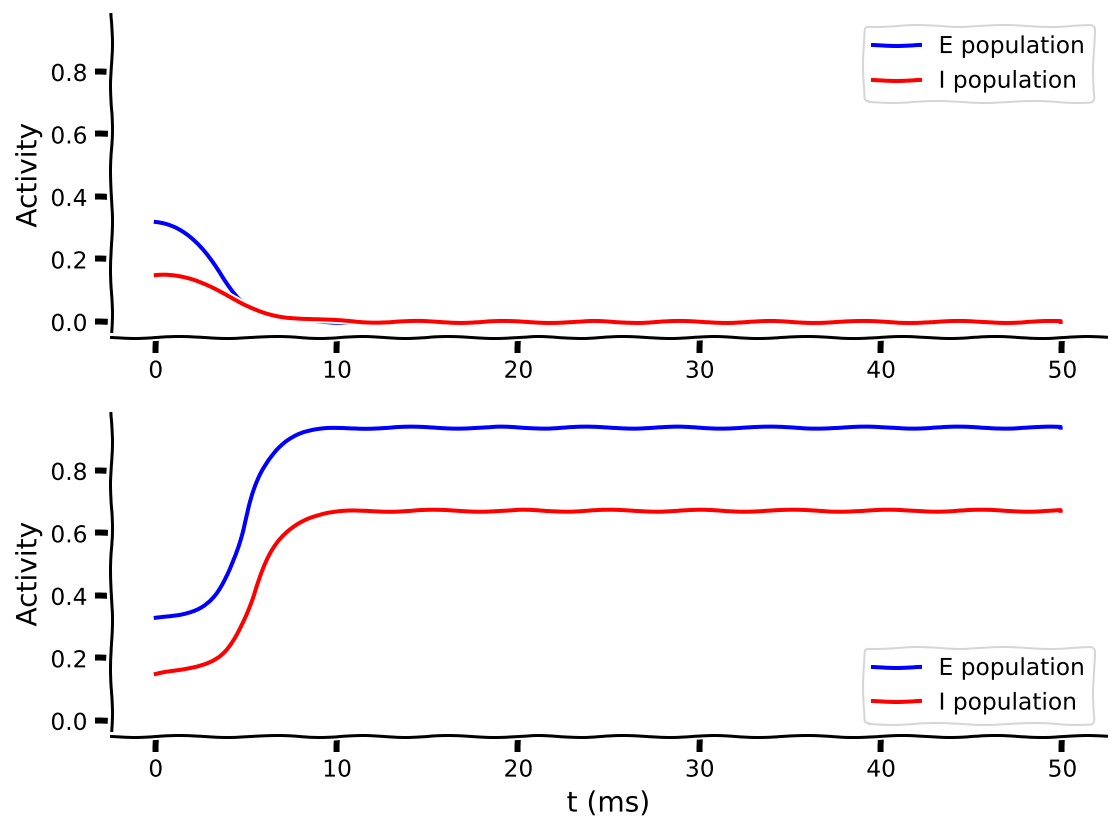

In [14]:
# to_remove solution
def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    # Calculate the derivative of the E population
    drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI


pars = default_pars()

# Simulate first trajectory
rE1, rI1 = simulate_wc(**default_pars(rE_init=.32, rI_init=.15))

# Simulate second trajectory
rE2, rI2 = simulate_wc(**default_pars(rE_init=.33, rI_init=.15))

# Visualize
with plt.xkcd():
  my_test_plot(pars['range_t'], rE1, rI1, rE2, rI2)

The two plots above show the temporal evolution of excitatory ($r_E$, blue) and inhibitory ($r_I$, red) activity for two different sets of initial conditions.

### Interactive Demo 1.2: population trajectories with different initial values
In this interactive demo, we will simulate the Wilson-Cowan model and plot the trajectories of each population. We change the initial activity of the excitatory population.


What happens to the E and I population trajectories with different initial conditions?



In [15]:
# @title

# @markdown Make sure you execute this cell to enable the widget!


def plot_EI_diffinitial(rE_init=0.0):

  pars = default_pars(rE_init=rE_init, rI_init=.15)
  rE, rI = simulate_wc(**pars)

  plt.figure()
  plt.plot(pars['range_t'], rE, 'b', label='E population')
  plt.plot(pars['range_t'], rI, 'r', label='I population')
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.show()


_ = widgets.interact(plot_EI_diffinitial, rE_init=(0.30, 0.35, .01))

interactive(children=(FloatSlider(value=0.3, description='rE_init', max=0.35, min=0.3, step=0.01), Output()), …

In [ ]:
# to_remove explanation

"""

Sometimes both the excitatory and inhibitory population activities decay to 0 and
sometimes they level out at different positive values.

"""

### Think! 1.2
It is evident that the steady states of the neuronal response can be different when different initial states are chosen. Why is that? 

We will discuss this in the next section but try to think about it first.

---
# Section 2: Phase plane analysis

*Estimated timing to here from start of tutorial: 45 min*

Just like we used a graphical method to study the dynamics of a 1-D system in the previous tutorial, here we will learn a  graphical approach called **phase plane analysis** to study the dynamics of a 2-D system like the Wilson-Cowan model. You have seen this before in the [pre-reqs calculus day](https://compneuro.neuromatch.io/tutorials/W0D4_Calculus/student/W0D4_Tutorial3.html#section-3-2-phase-plane-plot-and-nullcline) and on the [Linear Systems day](https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial1.html#section-4-stream-plots)

So far, we have plotted the activities of the two populations as a function of time, i.e., in the `Activity-t` plane, either the $(t, r_E(t))$ plane or the $(t, r_I(t))$ one. Instead, we can plot the two activities $r_E(t)$ and $r_I(t)$ against each other at any time point $t$. This characterization in the `rI-rE` plane $(r_I(t), r_E(t))$ is called the **phase plane**. Each line in the phase plane indicates how both $r_E$ and $r_I$ evolve with time.

In [16]:
# @title Video 2: Nullclines and Vector Fields
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV15k4y1m7Kt", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="V2SBAK2Xf8Y", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Interactive Demo 2: From the Activity - time plane to the **$r_I$ - $r_E$** phase plane

In this demo, we will visualize the system dynamics using both the `Activity-time` and the `(rE, rI)` phase plane. The circles indicate the activities at a given time $t$, while the lines represent the evolution of the system for the entire duration of the simulation.

Move the time slider to better understand how the top plot relates to the bottom plot. Does the bottom plot have explicit information about time? What information does it give us?

In [17]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

pars = default_pars(T=10, rE_init=0.6, rI_init=0.8)
rE, rI = simulate_wc(**pars)


def plot_activity_phase(n_t):
  plt.figure(figsize=(8, 5.5))
  plt.subplot(211)
  plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
  plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
  plt.plot(pars['range_t'][n_t], rE[n_t], 'bo')
  plt.plot(pars['range_t'][n_t], rI[n_t], 'ro')
  plt.axvline(pars['range_t'][n_t], 0, 1, color='k', ls='--')
  plt.xlabel('t (ms)', fontsize=14)
  plt.ylabel('Activity', fontsize=14)
  plt.legend(loc='best', fontsize=14)

  plt.subplot(212)
  plt.plot(rE, rI, 'k')
  plt.plot(rE[n_t], rI[n_t], 'ko')
  plt.xlabel(r'$r_E$', fontsize=18, color='b')
  plt.ylabel(r'$r_I$', fontsize=18, color='r')

  plt.tight_layout()
  plt.show()


_ = widgets.interact(plot_activity_phase, n_t=(0, len(pars['range_t']) - 1, 1))

interactive(children=(IntSlider(value=49, description='n_t', max=99), Output()), _dom_classes=('widget-interac…

In [ ]:
# to_remove explanation

"""
- Phase plane portraits allows us to visualize out of all possible states which
states a system can take. For example in this demo you see that the among all
possible pairs of values for r1 and r2, this system can take only a limited number
of states (those that lie on the black line).

- There are other things we can infer from the phase portraits e.g. fixed
points, trajectory to the fixed points etc.

- Explicit information about time is not visible in the phase portraits
""";

## Section 2.1: Nullclines of the Wilson-Cowan Equations

*Estimated timing to here from start of tutorial: 1 hour, 3 min*

An important concept in the phase plane analysis is the "nullcline" which is defined as the set of points in the phase plane where the activity of one population (but not necessarily the other) does not change.

In other words, the $E$ and $I$ nullclines of Equation $(1)$ are defined as the points where $\displaystyle{\frac{dr_E}{dt}}=0$, for the excitatory nullcline, or $\displaystyle\frac{dr_I}{dt}=0$ for the inhibitory nullcline. That is:

\begin{align}
-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E) &= 0  \qquad (2)\\[1mm]
-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I) &= 0    \qquad (3)
\end{align}

### Coding Exercise 2.1: Compute the nullclines of the Wilson-Cowan model

In the next exercise, we will compute and plot the nullclines of the E and I population.


Along the nullcline of excitatory population Equation $2$, you can calculate the inhibitory activity by rewriting Equation $2$ into

\begin{align}
r_I = \frac{1}{w_{EI}}\big{[}w_{EE}r_E - F_E^{-1}(r_E; a_E,\theta_E) + I^{\text{ext}}_E \big{]}. \qquad(4)
\end{align}

where $F_E^{-1}(r_E; a_E,\theta_E)$ is the inverse of the excitatory transfer function (defined below). Equation $4$ defines the $r_E$ nullcline.

Along the nullcline of inhibitory population Equation $3$, you can calculate the excitatory activity by rewriting Equation $3$ into 
\begin{align}
r_E = \frac{1}{w_{IE}} \big{[} w_{II}r_I + F_I^{-1}(r_I;a_I,\theta_I) - I^{\text{ext}}_I \big{]}.  \qquad (5)  
\end{align}

shere $F_I^{-1}(r_I; a_I,\theta_I)$ is the inverse of the inhibitory transfer function (defined below). Equation $5$ defines the $I$ nullcline.

Note that, when computing the nullclines with Equations 4-5, we also need to calculate the inverse of the transfer functions. \\

The inverse of the sigmoid shaped **f-I** function that we have been using is:

$$F^{-1}(x; a, \theta) = -\frac{1}{a} \ln \left[ \frac{1}{x + \displaystyle \frac{1}{1+\text{e}^{a\theta}}} - 1 \right] + \theta \qquad (6)$$

The first step is to implement the inverse transfer function:

<ipython-input-18-770bcac667c1>:18: RuntimeWarning: invalid value encountered in log
  F_inverse = ( - 1 / a ) * np.log( 1 / ( x + 1 / ( 1 + np.exp(a*theta) ) ) - 1 ) + theta


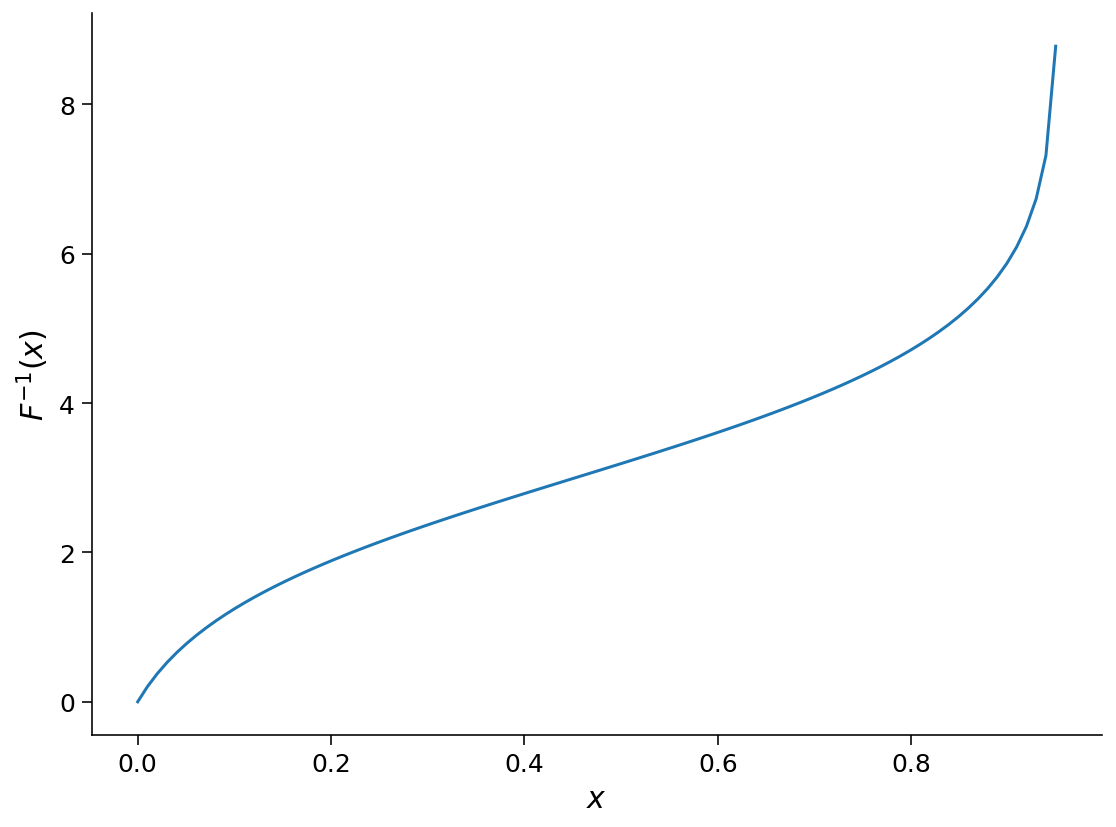

In [18]:
def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  #########################################################################
  # TODO for students: compute F_inverse
  #raise NotImplementedError("Student exercise: compute the inverse of F(x)")
  #########################################################################

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = ( - 1 / a ) * np.log( 1 / ( x + 1 / ( 1 + np.exp(a*theta) ) ) - 1 ) + theta

  return F_inverse


# Set parameters
pars = default_pars()
x = np.linspace(1e-6, 1, 100)

# Get inverse and visualize
plot_FI_inverse(x, a=1, theta=3)

<ipython-input-19-621e8eab9970>:14: RuntimeWarning: invalid value encountered in log
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


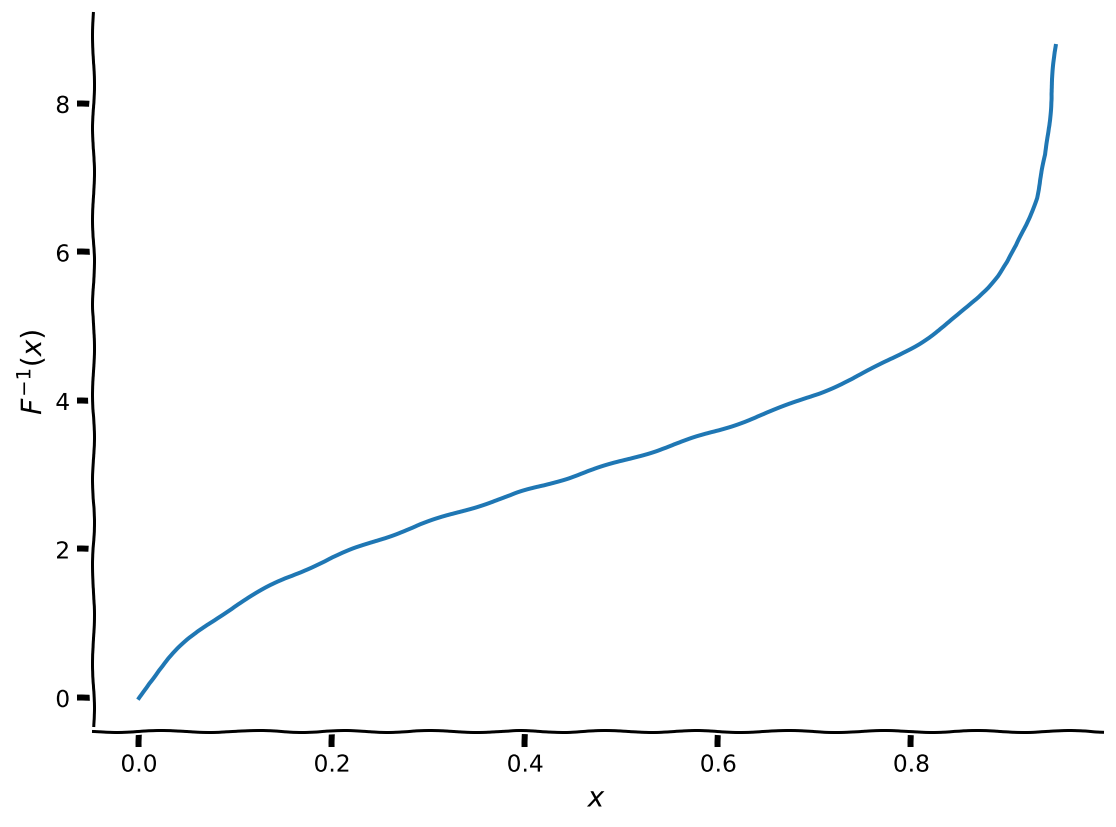

In [19]:
# to_remove solution
def F_inv(x, a, theta):
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function

  Returns:
    F_inverse : value of the inverse function
  """

  # Calculate Finverse (ln(x) can be calculated as np.log(x))
  F_inverse = -1/a * np.log((x + (1 + np.exp(a * theta))**-1)**-1 - 1) + theta

  return F_inverse


# Set parameters
pars = default_pars()
x = np.linspace(1e-6, 1, 100)

# Get inverse and visualize
with plt.xkcd():
  plot_FI_inverse(x, a=1, theta=3)

Now you can compute the nullclines, using Equations 4-5 (repeated here for ease of access):

\begin{align}
r_I = \frac{1}{w_{EI}}\big{[}w_{EE}r_E - F_E^{-1}(r_E; a_E,\theta_E) + I^{\text{ext}}_E \big{]}. \qquad(4)
\end{align}

\begin{align}
r_E = \frac{1}{w_{IE}} \big{[} w_{II}r_I + F_I^{-1}(r_I;a_I,\theta_I) - I^{\text{ext}}_I \big{]}.  \qquad (5)  
\end{align}

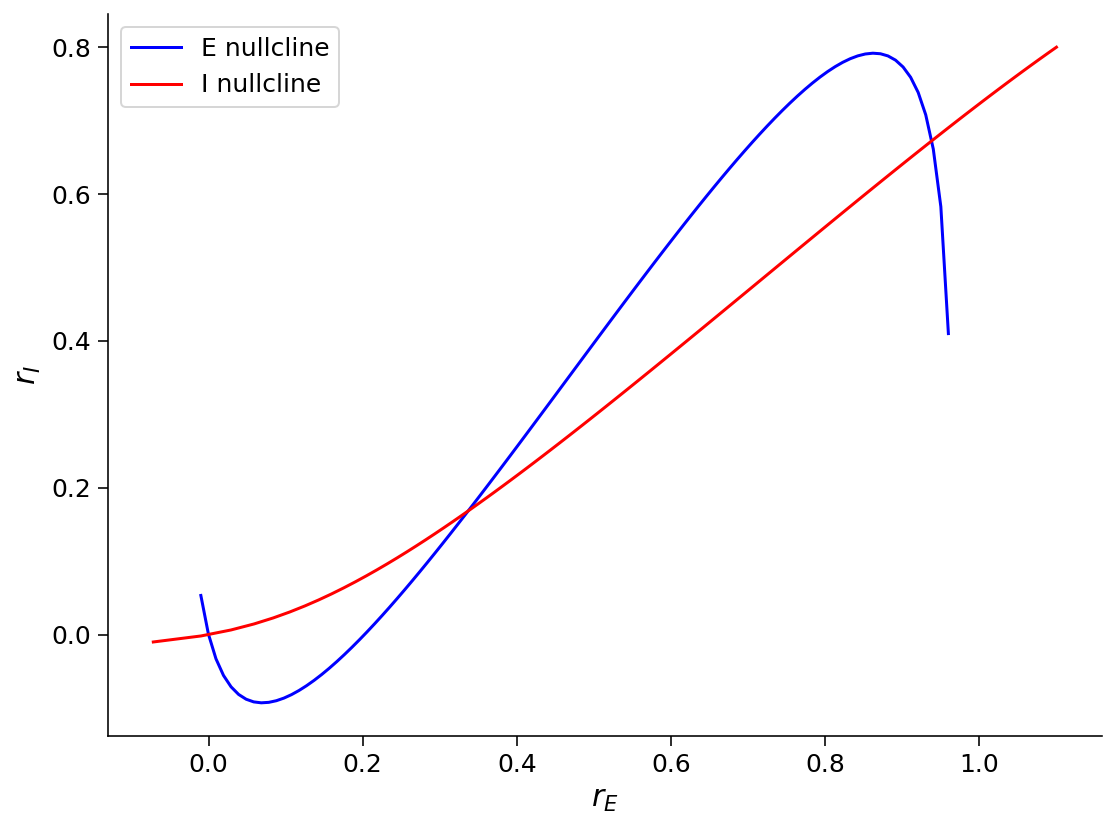

In [21]:
def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  #########################################################################
  # TODO for students: compute rI for rE nullcline and disable the error
  #raise NotImplementedError("Student exercise: compute the E nullcline")
  #########################################################################

  # calculate rI for E nullclines on rI
  rI = ( 1 / wEI ) * ( wEE*rE - F_inv(rE, a_E, theta_E) + I_ext_E )

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  #########################################################################
  # TODO for students: compute rI for rE nullcline and disable the error
  #raise NotImplementedError("Student exercise: compute the I nullcline")
  #########################################################################

  # calculate rE for I nullclines on rI
  rE = ( 1 / wIE ) * ( wII*rI + F_inv(rI, a_I, theta_I) - I_ext_I )

  return rE


# Set parameters
pars = default_pars()
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

# Visualize
plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI)

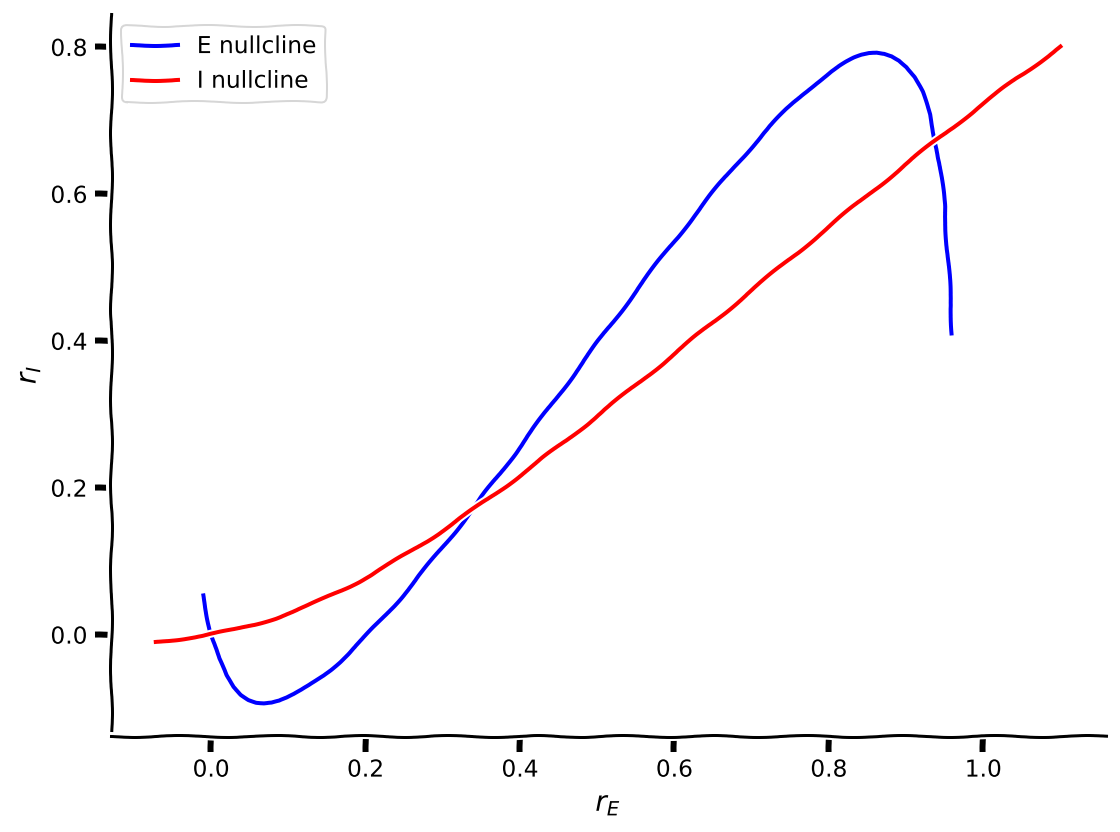

In [22]:
# to_remove solution
def get_E_nullcline(rE, a_E, theta_E, wEE, wEI, I_ext_E, **other_pars):
  """
  Solve for rI along the rE from drE/dt = 0.

  Args:
    rE    : response of excitatory population
    a_E, theta_E, wEE, wEI, I_ext_E : Wilson-Cowan excitatory parameters
    Other parameters are ignored

  Returns:
    rI    : values of inhibitory population along the nullcline on the rE
  """
  # calculate rI for E nullclines on rI
  rI = 1 / wEI * (wEE * rE - F_inv(rE, a_E, theta_E) + I_ext_E)

  return rI


def get_I_nullcline(rI, a_I, theta_I, wIE, wII, I_ext_I, **other_pars):
  """
  Solve for E along the rI from dI/dt = 0.

  Args:
    rI    : response of inhibitory population
    a_I, theta_I, wIE, wII, I_ext_I : Wilson-Cowan inhibitory parameters
    Other parameters are ignored

  Returns:
    rE    : values of the excitatory population along the nullcline on the rI
  """
  # calculate rE for I nullclines on rI
  rE = 1 / wIE * (wII * rI + F_inv(rI, a_I, theta_I) - I_ext_I)

  return rE


# Set parameters
pars = default_pars()
Exc_null_rE = np.linspace(-0.01, 0.96, 100)
Inh_null_rI = np.linspace(-.01, 0.8, 100)

# Compute nullclines
Exc_null_rI = get_E_nullcline(Exc_null_rE, **pars)
Inh_null_rE = get_I_nullcline(Inh_null_rI, **pars)

# Visualize
with plt.xkcd():
  plot_nullclines(Exc_null_rE, Exc_null_rI, Inh_null_rE, Inh_null_rI)

Note that by definition along the blue line in the phase-plane spanned by $r_E, r_I$, $\displaystyle{\frac{dr_E(t)}{dt}} = 0$, therefore, it is called a nullcline. 

That is, the blue nullcline divides the phase-plane spanned by $r_E, r_I$ into two regions: on one side of the nullcline $\displaystyle{\frac{dr_E(t)}{dt}} > 0$ and on the other side $\displaystyle{\frac{dr_E(t)}{dt}} < 0$.

The same is true for the red line along which $\displaystyle{\frac{dr_I(t)}{dt}} = 0$. That is, the red nullcline divides the phase-plane spanned by $r_E, r_I$ into two regions: on one side of the nullcline $\displaystyle{\frac{dr_I(t)}{dt}} > 0$ and on the other side $\displaystyle{\frac{dr_I(t)}{dt}} < 0$.


## Section 2.2: Vector field

*Estimated timing to here from start of tutorial: 1 hour, 20 min*

How can the phase plane and the nullcline curves help us understand the behavior of the Wilson-Cowan model? 

<details>
<summary> <font color='blue'>Click here for text recap of relevant part of video </font></summary>

The activities of the $E$ and $I$ populations $r_E(t)$ and $r_I(t)$ at each time point $t$ correspond to a single point in the phase plane, with coordinates $(r_E(t),r_I(t))$. Therefore, the time-dependent trajectory of the system can be described as a continuous curve in the phase plane, and the tangent vector to the trajectory, which is defined as the vector $\bigg{(}\displaystyle{\frac{dr_E(t)}{dt},\frac{dr_I(t)}{dt}}\bigg{)}$, indicates the direction towards which the activity is evolving and how fast is the activity changing along each axis. In fact, for each point $(E,I)$ in the phase plane, we can compute the tangent vector $\bigg{(}\displaystyle{\frac{dr_E}{dt},\frac{dr_I}{dt}}\bigg{)}$, which  indicates the behavior of the system when it traverses that point. 

The map of tangent vectors in the phase plane is called **vector field**. The behavior of any trajectory in the phase plane is determined by i) the initial conditions $(r_E(0),r_I(0))$, and ii) the vector field $\bigg{(}\displaystyle{\frac{dr_E(t)}{dt},\frac{dr_I(t)}{dt}}\bigg{)}$.

In general, the value of the vector field at a particular point in the phase plane is represented by an arrow. The orientation and the size of the arrow reflect the direction and the norm of the vector, respectively.

### Coding Exercise 2.2: Compute and plot the vector field $\displaystyle{\Big{(}\frac{dr_E}{dt}, \frac{dr_I}{dt} \Big{)}}$

Note that

\begin{align}
\frac{dr_E}{dt} &= [-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a_E,\theta_E)]\frac{1}{\tau_E}\\
\frac{dr_I}{dt} &= [-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a_I,\theta_I)]\frac{1}{\tau_I}    
\end{align}

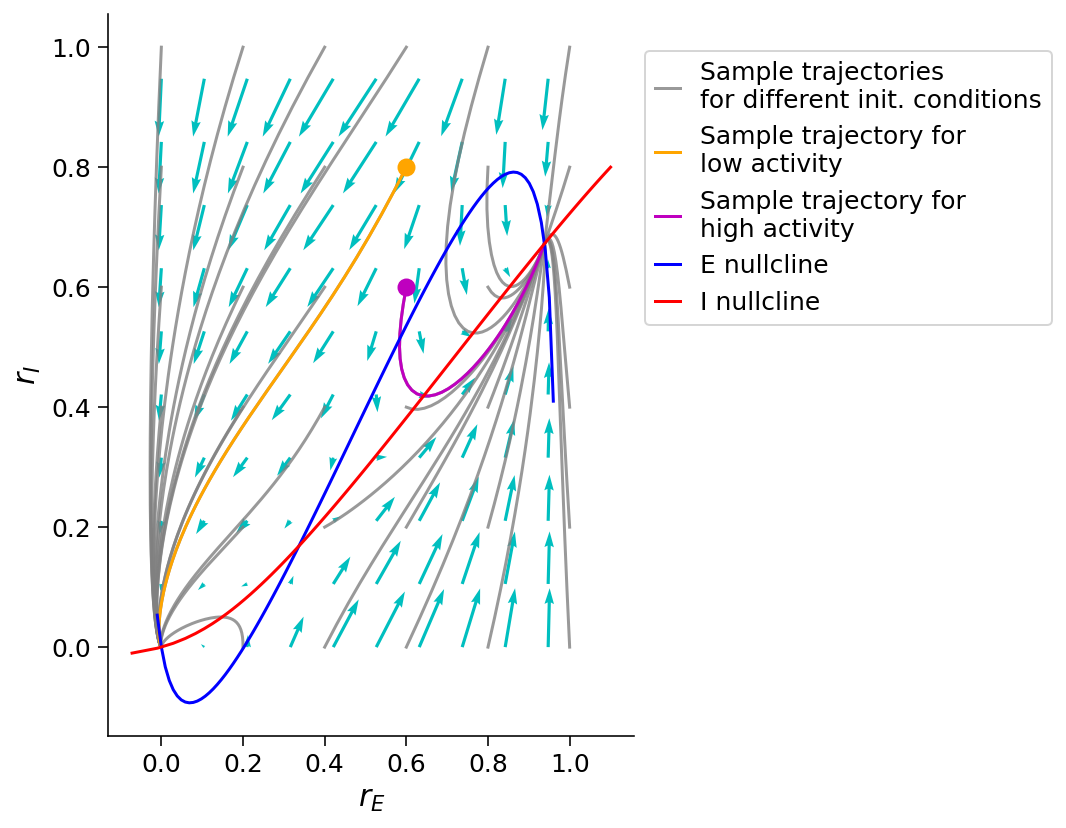

In [23]:
def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""
  ######################################################################
  # TODO for students: compute drEdt and drIdt and disable the error
  #raise NotImplementedError("Student exercise: compute the vector field")
  ######################################################################

  # Compute the derivative of rE
  drEdt = (1 / tau_E) * ( -rE + F(wEE*rE - wEI*rI + I_ext_E, a_E, theta_E) )

  # Compute the derivative of rI
  drIdt = (1 / tau_I) * ( -rI + F(wIE*rE - wII*rI + I_ext_I, a_I, theta_I) )

  return drEdt, drIdt


# Create vector field using EIderivs
plot_complete_analysis(default_pars())

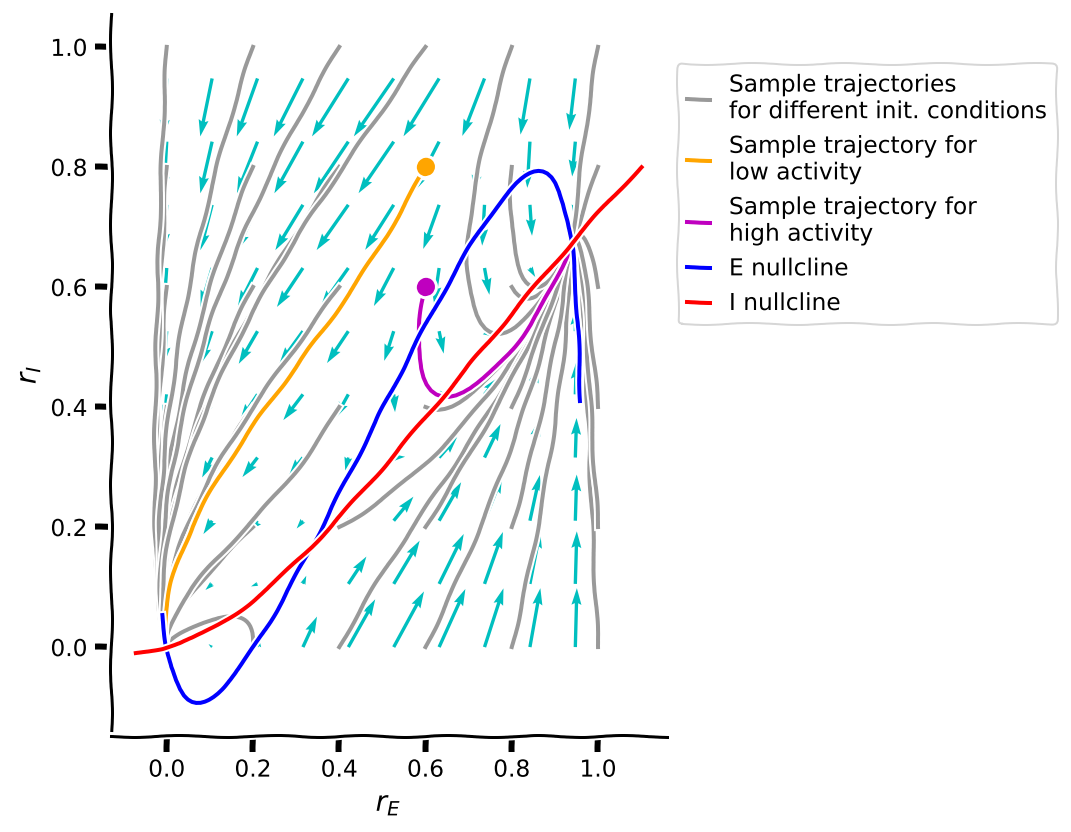

In [24]:
# to_remove solution
def EIderivs(rE, rI,
             tau_E, a_E, theta_E, wEE, wEI, I_ext_E,
             tau_I, a_I, theta_I, wIE, wII, I_ext_I,
             **other_pars):
  """Time derivatives for E/I variables (dE/dt, dI/dt)."""

  # Compute the derivative of rE
  drEdt = (-rE + F(wEE * rE - wEI * rI + I_ext_E, a_E, theta_E)) / tau_E

  # Compute the derivative of rI
  drIdt = (-rI + F(wIE * rE - wII * rI + I_ext_I, a_I, theta_I)) / tau_I

  return drEdt, drIdt


# Create vector field using EIderivs
with plt.xkcd():
  plot_complete_analysis(default_pars())


The last phase plane plot shows us that: 
- Trajectories seem to follow the direction of the vector field
- Different trajectories eventually always reach one of two points depending on the initial conditions. 
- The two points where the trajectories converge are the intersection of the two nullcline curves. 

## Think! 2.2: Analyzing the vector field

There are, in total, three intersection points, meaning that the system has three fixed points.

1. One of the fixed points (the one in the middle) is never the final state of a trajectory. Why is that? 
2. Why the arrows tend to get smaller as they approach the fixed points?

In [ ]:
# to_remove explanation

"""

1. Because the middle fixed point is unstable. Trajectories only point to stable
fixed points.

2. The slope of dr/dt determines the speed at which the system states will evolve.
At the nullclines dr_e/dt = 0 and/or dr_i/dt = 0. That means as we move close to
the nullclines the dr/dt becomes smaller and smaller. Therefore the system state
evolves slower and slower as we approach the nullcline.
""";

---
# Summary

*Estimated timing of tutorial: 1 hour, 35 minutes*

Congratulations! You have finished the fourth day of the second week of the neuromatch academy! Here, you learned how to simulate a rate based model consisting of excitatory and inhibitory population of neurons.

In the last tutorial on dynamical neuronal networks you learned to:
- Implement and simulate a 2D system composed of an E and an I population of neurons using the **Wilson-Cowan** model
- Plot the frequency-current (F-I) curves for both populations
- Examine the behavior of the system using phase **plane analysis**, **vector fields**, and **nullclines**.

Do you have more time? Have you finished early? We have more fun material for you! 

In the bonus tutorial, there are some, more advanced concepts on dynamical systems:

- You will learn how to find the fixed points on such a system, and to investigate its stability by linearizing its dynamics and examining the **Jacobian matrix**.
- You will see identify conditions under which the Wilson-Cowan model can exhibit oscillations.

If you need even more, there are two applications of the Wilson-Cowan model:

- Visualization of an Inhibition-stabilized network
- Simulation of working memory